In [1]:
%load_ext autoreload
%autoreload 2

import os

import jax
jax.config.update("jax_enable_x64", True)

import numpyro
numpyro.set_host_device_count(4)

import numpy as np
import scipy.optimize

import ultraplot as uplt

In [2]:
from des_y6_imsim_analysis import bump
from des_y6_imsim_analysis.stats import compute_model_chi2_info, measure_map, run_mcmc
from des_y6_imsim_analysis.utils import measure_m_dz, read_data

In [3]:
fnames = [
    "../../data/N_gamma_alpha_v2_statistical.hdf5",
    "../../data/N_gamma_alpha_v2_statistical-occupancy.hdf5",
    "../../data/N_gamma_alpha_v2_statistical-neighbor.hdf5",
    "../../data/N_gamma_alpha_v2_statistical-neighbor-occupancy.hdf5",
]

keys = [
    os.path.basename(fname).replace(".hdf5", "").split("_")[-1]
    for fname in fnames
]

seeds = [213432, 6457645, 213, 7878546]

fit_data = {}

model_module = bump

for key, fname, seed in zip(keys, fnames, seeds):
    data = read_data(fname)

    model_data = model_module.make_model_data(
        z=data.z,
        nzs=data.nzs,
        mn=data.mn,
        cov=data.cov,
        mn_pars=data.mn_pars,
        zbins=data.zbins,
        fixed_param_values={"w": 0.1, "g_b0": 0.0, "g_b1": 0.0, "g_b2": 0.0, "g_b3": 0.0},
        num_bins=9,
    )

    map_params = measure_map(
        model_module=model_module,
        model_data=model_data,
        seed=seed,
    )

    mcmc = run_mcmc(
        model_module=model_module,
        model_data=model_data,
        init_params=map_params,
        seed=seed,
    )

    chi2_info = compute_model_chi2_info(
        model_module=model_module,
        model_data=model_data,
        data=data,
        params=map_params,
    )

    fit_data[key] = {
        "map_params": map_params,
        "mcmc": mcmc,
        "model_data": model_data,
        "data": data,
    }

    print("key:", key)
    print("chi2:", chi2_info['chi2'])
    print("dof:", chi2_info['dof'])
    print("p-value:", chi2_info['p_value'])
    print("m vals:\n    model: %r\n    data: %r\n     err: %r" % (
        (chi2_info['model_mn'][:4] - 1).tolist(),
        (data.mn[:4] - 1).tolist(),
        (np.sqrt(np.diag(data.cov)[:4])).tolist(),
    ))
    print("", flush=True)

key: statistical
chi2: 3.832692091685576
dof: 8
p-value: 0.87189417323875
m vals:
    model: [-0.005961562361381678, 0.014455806637001523, 0.016856872871886308, 0.009677856668955265]
    data: [-0.006994349826206503, 0.016036566228740057, 0.017247239530250313, 0.009428620061380233]
     err: [0.004593226944328782, 0.006142812018330256, 0.005437871858005932, 0.009363355942622971]

key: statistical-occupancy
chi2: 4.016246685503746
dof: 8
p-value: 0.8556546585114898
m vals:
    model: [-0.008156223707055155, 0.010562624931793163, 0.016423324155631747, 0.008193864775689175]
    data: [-0.008923099284016134, 0.012461296733357496, 0.017138348042496254, 0.007125125944023258]
     err: [0.005081500549334836, 0.006317458726575935, 0.005407761042726535, 0.009482393424392194]

key: statistical-neighbor
chi2: 5.98443953225779
dof: 8
p-value: 0.6489749805732526
m vals:
    model: [-0.004360889281021851, 0.0102167419533723, 0.019093082171642184, 0.0061169702173813345]
    data: [-0.0060081569373531

In [4]:
desnz = np.load("Tz_realizations_WZ_bq_pile4_0d05.npy")

In [11]:
import tqdm

from des_y6_imsim_analysis.utils import compute_nz_binned_mean, sompz_integral

rng = np.random.default_rng(462552)

mvals = {}
dzvals = {}
finalnzs = {}

keys = list(fit_data.keys())

for key in keys:
    samples = fit_data[key]["mcmc"].get_samples()

    key_mvals = []
    key_dzvals = []
    key_finalnzs = []
    for i in tqdm.trange(desnz.shape[0], ncols=80, desc=f"{key}:"):

        rind = rng.choice(samples["w"].shape[0])

        params = {
            k: samples[k][rind] for k in samples.keys()
        }
        nz = desnz[i, :].copy()
        for _i in range(4):
            nz[_i, :] = nz[_i, :] / np.sum(nz[_i, :])
        model_nz = model_module.model_mean_smooth(
            pts=model_data["pts"],
            z=model_data["z"],
            nz=nz,
            mn_pars=model_data["mn_pars"],
            zbins=model_data["zbins"],
            params=params,
            mn=None,
            cov=None,
        )

        model_nz = np.array(model_nz)

        key_mvals.append([
            float(sompz_integral(model_nz[_i, :], 0, 6) - 1)
            for _i in range(4)
        ])

        for _i in range(4):
            model_nz[_i, :] = model_nz[_i, :] / np.sum(model_nz[_i, :])

        key_finalnzs.append(model_nz)
        key_dzvals.append([
            float(compute_nz_binned_mean(model_nz[_i, :]) - compute_nz_binned_mean(nz[_i, :]))
            for _i in range(4)
        ])

    mvals[key] = np.array(key_mvals)
    dzvals[key] = np.array(key_dzvals)
    finalnzs[key] = np.array(key_finalnzs)

statistical-neighbor-occupancy: 100%|████| 10095/10095 [00:16<00:00, 600.00it/s]


In [14]:
import h5py

with h5py.File("des_y6_nz_data_imsim_v2.h5", "w") as fp:
    for key in keys:
        fp.create_dataset(f"{key}/m", data=mvals[key])
        fp.create_dataset(f"{key}/dz", data=dzvals[key])
        fp.create_dataset(f"{key}/nz", data=finalnzs[key])

In [9]:
key = "statistical"

m_mn = [np.mean(mvals[key][:, i]) for i in range(4)]
m_sd = [np.std(mvals[key][:, i]) for i in range(4)]

dz_mn = [np.mean(dzvals[key][:, i]) for i in range(4)]
dz_sd = [np.std(dzvals[key][:, i]) for i in range(4)]

print("|--------------------------------------------|")
print("| bin | m [10^-3, 3sigma] | dz               |")
print("|--------------------------------------------|")
for i in range(4):
    print(
        "| %d   | %+5.1f +/- %-5.1f   | %+0.3f +/- %0.3f |" % (
            i, m_mn[i]/1e-3, m_sd[i]/1e-3 * 3, dz_mn[i], dz_sd[i]
        )
    )
print("|--------------------------------------------|")

|--------------------------------------------|
| bin | m [10^-3, 3sigma] | dz               |
|--------------------------------------------|
| 0   |  +0.5 +/- 18.7    | -0.019 +/- 0.008 |
| 1   |  +7.4 +/- 21.4    | -0.033 +/- 0.010 |
| 2   | +21.6 +/- 20.2    | -0.006 +/- 0.006 |
| 3   |  -7.0 +/- 36.8    | -0.045 +/- 0.012 |
|--------------------------------------------|


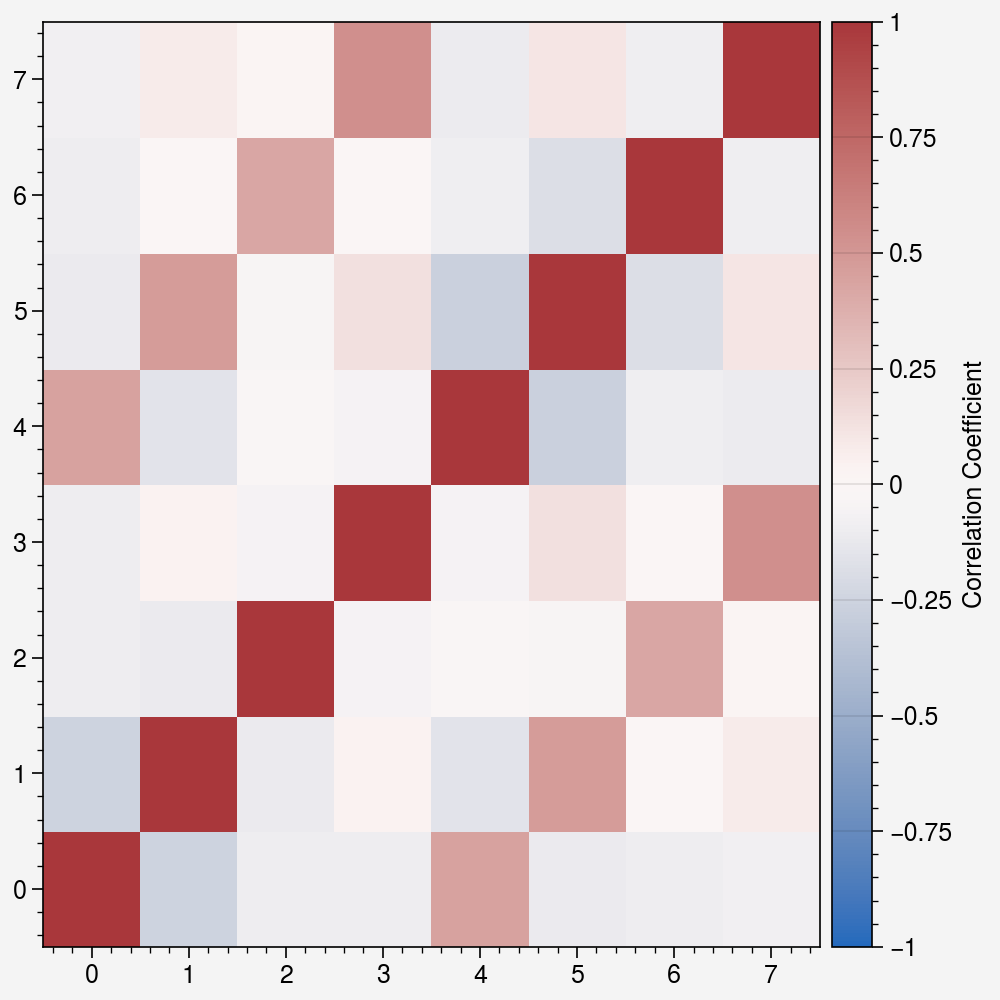

In [10]:
mdz = np.concatenate([mvals[key], dzvals[key]], axis=1)

corr = np.corrcoef(mdz.T)

fig, axs = uplt.subplots(figsize=(5, 5))

m = axs.pcolormesh(corr, vmin=-1, vmax=1, cmap="vlag", discrete=False)
axs.colorbar(m, label="Correlation Coefficient")
axs.format(grid=False)